In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fml-last-assignment/Data for EM.odt
/kaggle/input/fml-last-assignment/creditcard-test.xlsx
/kaggle/input/fml-last-assignment/IRIS.csv
/kaggle/input/fml-last-assignment/creditcard.csv
/kaggle/input/fml-last-assignment/flipkart_product.csv


## (i) Apply Anomaly detection to remove noise and irrelevant information, PCA for dimensionality reduction with 95% of information retrieval, and K-means algorithm to classify the following datasets (40M) (a) Flower Data set: https://www.kaggle.com/datasets/arshid/iris-flower-dataset. Test optimal ‘k’ using the Elbow method considering k=2 to k=5. Note: Use k-means/knn or Z-score method for Anomaly detection.  

Original dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

After anomaly detection:
Remaining samples: 144
Removed samples: 6

PCA results:
Number of components selected: 2
Explained variance ratio: [0.75246233 0.20464642]
Cumulative explained variance: 0.957108751988387
Transformed data shape: (144, 2)

Cluster vs. Actual Class Distribution for k=3:
Actual Class   0   1   2
Cluster                 
0              0  13  38
1             49   0   0
2              0  37   7
Simplified clustering accuracy: 0.8611


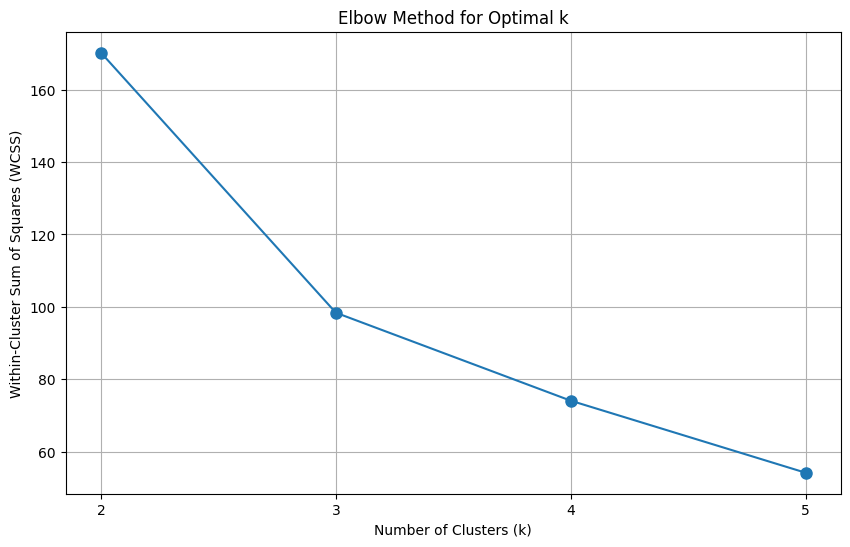

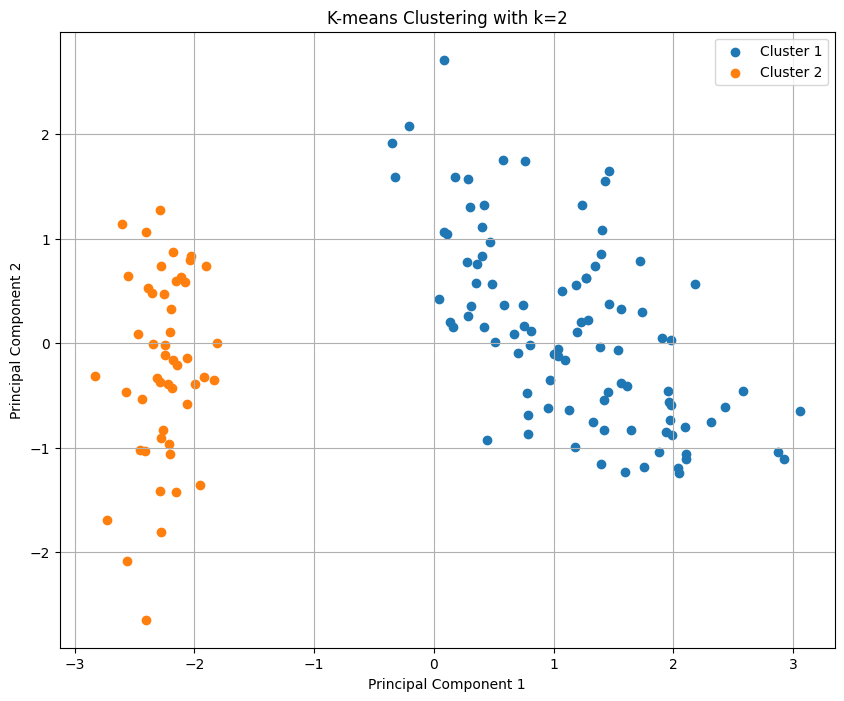

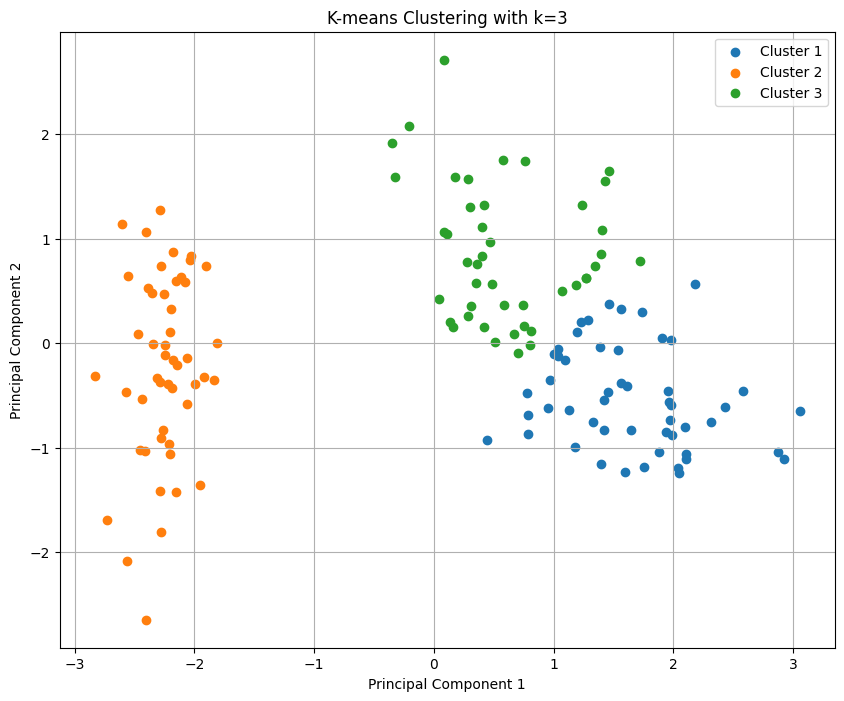

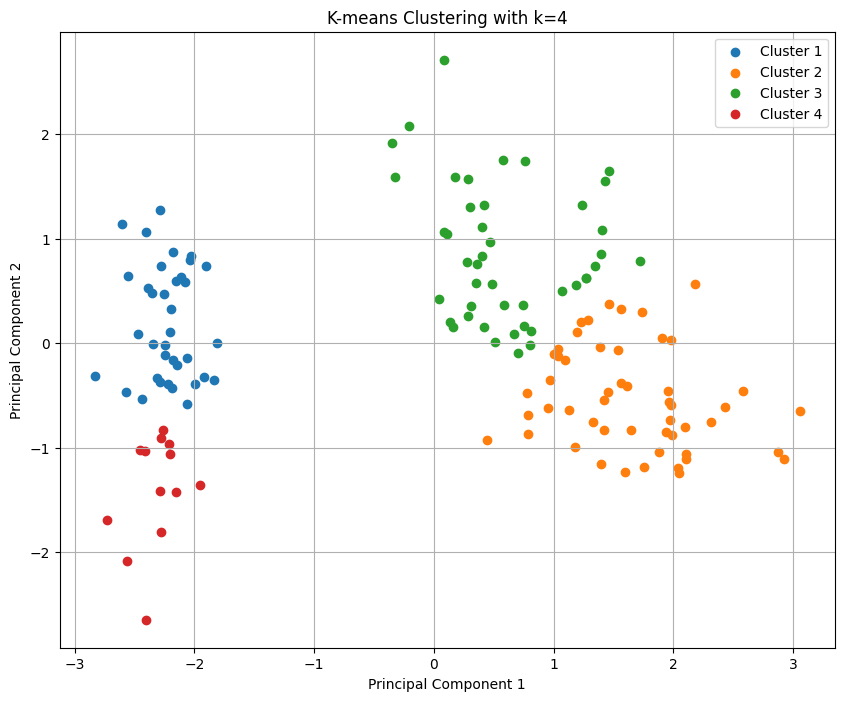

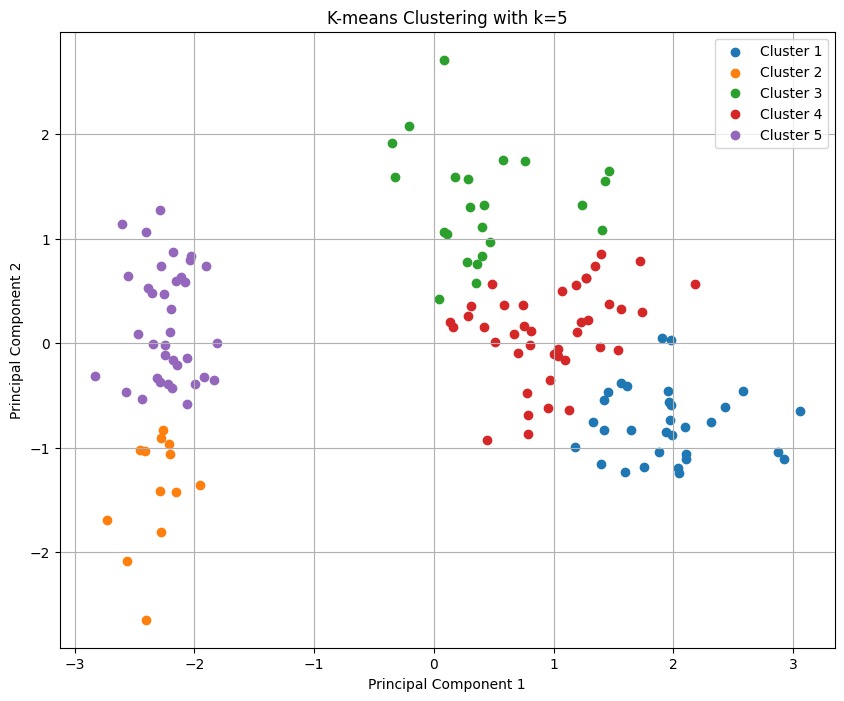

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Set random seed for reproducibility
np.random.seed(42)

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("Original dataset shape:", X.shape)
print("Features:", feature_names)
print("Classes:", target_names)

def detect_outliers_knn(data, n_neighbors=5, threshold=1.5):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(data)
    
    distances, _ = knn.kneighbors(data)
    
    avg_distances = np.mean(distances, axis=1)
    
    q1 = np.percentile(avg_distances, 25)
    q3 = np.percentile(avg_distances, 75)
    iqr = q3 - q1
    
    upper_bound = q3 + threshold * iqr
    
    non_outlier_indices = avg_distances <= upper_bound
    
    return non_outlier_indices

filtered_indices = detect_outliers_knn(X)
X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

print("\nAfter anomaly detection:")
print("Remaining samples:", X_filtered.shape[0])
print("Removed samples:", X.shape[0] - X_filtered.shape[0])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("\nPCA results:")
print("Number of components selected:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.sum(pca.explained_variance_ratio_))
print("Transformed data shape:", X_pca.shape)

wcss = []
k_range = range(2, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'o-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.xticks(k_range)
plt.savefig('elbow_method.png')

def plot_clusters(X_pca, labels, k, title):
    plt.figure(figsize=(10, 8))
    
    # Plot the first 2 PCA components
    for i in range(k):
        plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], 
                   label=f'Cluster {i+1}')
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'kmeans_k{k}.png')

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    # Plot the clusters
    plot_clusters(X_pca, labels, k, f'K-means Clustering with k={k}')
    
    if k == 3:  # Since Iris has 3 classes
        comparison_df = pd.DataFrame({
            'Cluster': labels,
            'Actual Class': y_filtered
        })
        
        print(f"\nCluster vs. Actual Class Distribution for k={k}:")
        contingency_table = pd.crosstab(comparison_df['Cluster'], 
                                        comparison_df['Actual Class'], 
                                        rownames=['Cluster'], 
                                        colnames=['Actual Class'])
        print(contingency_table)
        cluster_to_class = {}
        for cluster in range(k):
            class_counts = contingency_table.loc[cluster]
            cluster_to_class[cluster] = class_counts.idxmax()
        
        correct = 0
        for i, (cluster, actual) in enumerate(zip(labels, y_filtered)):
            if cluster_to_class[cluster] == actual:
                correct += 1
        
        accuracy = correct / len(y_filtered)
        print(f"Simplified clustering accuracy: {accuracy:.4f}")




## ii) Apply Anomaly detection to remove noise and irrelevant information, PCA for dimensionality reduction with 95% of information retrieval, and K-means algorithm to classify the following datasets Hyperspectral Data set: Washington DC MALL. Note: Use k-means/knn or Z-score method for Anomaly detection

In [3]:
from datasets import load_dataset

df = load_dataset("danaroth/washington_dc_mall")

README.md:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

ReadMe.txt:   0%|          | 0.00/207 [00:00<?, ?B/s]

wavelengths.txt:   0%|          | 0.00/3.23k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/214 [00:00<?, ? examples/s]

In [4]:
df

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 214
    })
})

In [5]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("danaroth/washington_dc_mall")

# Print the full DatasetDict
print(dataset)

# Access the 'train' split and print each record
for record in dataset['train']:
    print(record)


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 214
    })
})
{'text': 'The hyperspectral data set (dc.tif) of the Washington, DC mall area is provided with the permission of Spectral Information Technology Application Center of Virginia who was responsible for its collection.'}
{'text': 'Wavelength Table for August 23, 1995 Hydice Data Set over DC'}
{'text': ''}
{'text': '210 Channel Set - Center Wavelength (um)- 191 Channel Set'}
{'text': '1 401.288 1'}
{'text': '2 404.590 2'}
{'text': '3 407.919 3'}
{'text': '4 411.279 4'}
{'text': '5 414.671 5'}
{'text': '6 418.100 6'}
{'text': '7 421.568 7'}
{'text': '8 425.078 8'}
{'text': '9 428.632 9'}
{'text': '10 432.235 10'}
{'text': '11 435.888 11'}
{'text': '12 439.595 12'}
{'text': '13 443.358 13'}
{'text': '14 447.182 14'}
{'text': '15 451.067 15'}
{'text': '16 455.019 16'}
{'text': '17 459.040 17'}
{'text': '18 463.134 18'}
{'text': '19 467.302 19'}
{'text': '20 471.550 20'}
{'text': '21 475.880 21'}
{'t

In [6]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
dataset = load_dataset("danaroth/washington_dc_mall")
data = dataset['train']
texts = data['text']

def parse_numeric_row(text):
    tokens = text.split()
    if len(tokens) == 3:
        row = []
        for token in tokens:
            try:
                row.append(float(token))
            except ValueError:
                row.append(np.nan)  
        return row
    return None

numeric_data = [parse_numeric_row(row) for row in texts if parse_numeric_row(row) is not None]

df_numeric = pd.DataFrame(numeric_data, columns=['col1', 'col2', 'col3'])
print("Extracted numeric data (with NaN for missing values):")
display(df_numeric)


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_numeric)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X_imputed)
X_inliers = X_imputed[y_pred == 1]

print("\nData after removing anomalies:")
print(X_inliers)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_inliers)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("\nData after PCA (reduced dimensions):")
print(X_pca)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print("\nCluster labels for each data point:")
print(clusters)


Extracted numeric data (with NaN for missing values):


,col1,col2,col3
0,1.0,401.288,1.0
1,2.0,404.590,2.0
2,3.0,407.919,3.0
3,4.0,411.279,4.0
4,5.0,414.671,5.0
...,...,...,...
205,206.0,2473.160,191.0
206,207.0,2481.410,NaN
207,208.0,2489.630,NaN
208,209.0,2497.810,NaN



Data after removing anomalies:
[[   7.     421.568    7.   ]
 [   8.     425.078    8.   ]
 [   9.     428.632    9.   ]
 [  10.     432.235   10.   ]
 [  11.     435.888   11.   ]
 [  12.     439.595   12.   ]
 [  13.     443.358   13.   ]
 [  14.     447.182   14.   ]
 [  15.     451.067   15.   ]
 [  16.     455.019   16.   ]
 [  17.     459.04    17.   ]
 [  18.     463.134   18.   ]
 [  19.     467.302   19.   ]
 [  20.     471.55    20.   ]
 [  21.     475.88    21.   ]
 [  22.     480.298   22.   ]
 [  23.     484.805   23.   ]
 [  24.     489.406   24.   ]
 [  25.     494.105   25.   ]
 [  26.     498.906   26.   ]
 [  27.     503.814   27.   ]
 [  28.     508.832   28.   ]
 [  29.     513.966   29.   ]
 [  30.     519.221   30.   ]
 [  31.     524.6     31.   ]
 [  32.     530.109   32.   ]
 [  33.     535.752   33.   ]
 [  34.     541.537   34.   ]
 [  35.     547.467   35.   ]
 [  36.     553.547   36.   ]
 [  37.     559.784   37.   ]
 [  38.     566.183   38.   ]
 [  39. 

## 2. Apply PCA for dimensionality reduction with 95% of information retrieval, and Hierarchical clustering algorithm to predict credit card fraud. (20M) https://www.kaggle.com/datasets/nishipatkar/credit-card-details Predict credit card fraud for the test data: creditcard-test.xls (from assignment-2)

In [7]:
df_train=pd.read_csv("/kaggle/input/fml-last-assignment/creditcard.csv").iloc[:25000,:]

In [8]:
df_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,33469.0,-0.311372,0.759277,1.650994,1.091764,0.747545,0.924909,0.675067,-0.052870,-0.170135,...,-0.040939,0.357128,-0.406407,-0.871783,0.265729,-0.089932,-0.000652,-0.116323,20.00,0
24996,33469.0,-0.745983,0.518650,1.533865,1.335173,0.376647,0.019838,0.221768,0.328102,-0.390842,...,0.054737,0.314848,-0.034032,0.218806,-0.161277,-0.250516,0.402972,0.202283,18.04,0
24997,33470.0,-0.618962,1.302587,1.182654,-0.046862,0.267769,-0.527204,0.658724,0.029762,-0.331111,...,-0.259006,-0.529602,0.006277,0.042659,-0.155856,0.103680,0.378294,0.154449,1.79,0
24998,33471.0,1.377620,-0.279881,0.119446,-0.594892,-0.764533,-1.241617,-0.010524,-0.388173,-1.259304,...,-0.784787,-1.841549,0.264707,0.388256,0.013974,0.618726,-0.072529,0.013620,25.48,0


In [9]:
df_test=pd.read_excel("/kaggle/input/fml-last-assignment/creditcard-test.xlsx")
df_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11707,7.28,-0.53,8.17,9.32,1.11,0.53,-0.43,9.69,9.72,...,-0.95,6.07,1.13,0.46,9.82,3.30,5.07,-0.71,-0.91,958.184120
1,75775,0.76,5.92,-0.69,-0.49,7.88,1.13,6.90,3.62,0.00,...,0.22,3.35,0.10,5.18,1.85,4.39,-0.24,8.38,8.82,822.209306
2,50010,-0.92,7.57,6.30,2.68,2.93,0.32,5.06,0.15,5.29,...,3.34,6.11,5.35,7.84,7.02,-0.73,2.97,2.22,5.75,61.662134
3,11996,4.00,1.22,0.65,4.29,7.33,-0.45,1.19,1.57,7.58,...,0.25,4.94,0.20,3.60,2.41,3.28,8.67,6.05,5.99,956.869145
4,3360,8.60,6.43,-0.34,10.00,0.36,7.91,4.96,8.80,3.94,...,2.21,4.96,6.72,9.73,8.07,0.11,8.31,9.96,7.78,159.284273
5,71278,2.63,-0.31,3.91,1.75,-0.12,0.89,8.17,1.13,5.53,...,5.41,7.10,8.75,5.97,-0.26,9.98,5.18,2.07,1.04,282.008097
6,15904,8.27,4.01,6.60,8.61,6.04,9.74,6.60,3.67,9.28,...,3.94,8.75,6.50,9.99,3.69,3.92,8.26,-0.66,6.67,109.150863
7,47645,7.86,2.27,0.87,9.47,6.45,-0.12,1.41,0.68,8.83,...,2.97,2.65,5.60,2.94,4.44,4.70,9.25,2.96,-0.68,839.448067
8,40430,0.27,1.17,5.53,4.90,9.94,7.12,6.69,6.89,3.64,...,0.38,5.44,5.75,-0.20,9.61,7.96,-0.52,-0.71,3.52,120.055819
9,14347,1.85,9.79,0.96,0.00,8.24,2.39,0.28,8.34,9.68,...,5.35,1.87,4.88,9.15,2.60,2.51,-0.89,3.61,-0.93,201.238715


In [10]:
df_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
df_test.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)


df_train shape: (25000, 31)
df_test shape: (10, 30)


In [13]:
df_train['Class'].value_counts()

Class
0    24912
1       88
Name: count, dtype: int64

In [14]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from imblearn.over_sampling import SMOTE

feature_cols = [col for col in df_train.columns if col != 'Class']

X_train = df_train[feature_cols].values  # 30 features
y_train = df_train['Class'].values         # True labels for training data

X_test = df_test[feature_cols].values

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced training data shape: {X_train_pca.shape}")
print(f"PCA reduced test data shape: {X_test_pca.shape}")

agg_cluster = AgglomerativeClustering(n_clusters=2)
train_clusters = agg_cluster.fit_predict(X_train_pca)

cluster_label_mapping = {}
for cluster in np.unique(train_clusters):
    indices = np.where(train_clusters == cluster)[0]
    majority_class = np.bincount(y_train_bal[indices]).argmax()  
    cluster_label_mapping[cluster] = majority_class

print("Cluster to class mapping:", cluster_label_mapping)

centroids = []
for cluster in np.unique(train_clusters):
    centroid = np.mean(X_train_pca[train_clusters == cluster], axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

distances = cdist(X_test_pca, centroids, metric='euclidean')
test_cluster_assignments = np.argmin(distances, axis=1)

test_predictions = np.array([cluster_label_mapping[cluster] for cluster in test_cluster_assignments])

df_test['predicted_class'] = test_predictions
print(df_test[['predicted_class']].head())


PCA reduced training data shape: (49824, 1)
PCA reduced test data shape: (10, 1)
Cluster to class mapping: {0: 0, 1: 1}
   predicted_class
0                1
1                0
2                0
3                1
4                1


In [15]:
df_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,predicted_class
0,11707,7.28,-0.53,8.17,9.32,1.11,0.53,-0.43,9.69,9.72,...,6.07,1.13,0.46,9.82,3.30,5.07,-0.71,-0.91,958.184120,1
1,75775,0.76,5.92,-0.69,-0.49,7.88,1.13,6.90,3.62,0.00,...,3.35,0.10,5.18,1.85,4.39,-0.24,8.38,8.82,822.209306,0
2,50010,-0.92,7.57,6.30,2.68,2.93,0.32,5.06,0.15,5.29,...,6.11,5.35,7.84,7.02,-0.73,2.97,2.22,5.75,61.662134,0
3,11996,4.00,1.22,0.65,4.29,7.33,-0.45,1.19,1.57,7.58,...,4.94,0.20,3.60,2.41,3.28,8.67,6.05,5.99,956.869145,1
4,3360,8.60,6.43,-0.34,10.00,0.36,7.91,4.96,8.80,3.94,...,4.96,6.72,9.73,8.07,0.11,8.31,9.96,7.78,159.284273,1
5,71278,2.63,-0.31,3.91,1.75,-0.12,0.89,8.17,1.13,5.53,...,7.10,8.75,5.97,-0.26,9.98,5.18,2.07,1.04,282.008097,0
6,15904,8.27,4.01,6.60,8.61,6.04,9.74,6.60,3.67,9.28,...,8.75,6.50,9.99,3.69,3.92,8.26,-0.66,6.67,109.150863,1
7,47645,7.86,2.27,0.87,9.47,6.45,-0.12,1.41,0.68,8.83,...,2.65,5.60,2.94,4.44,4.70,9.25,2.96,-0.68,839.448067,0
8,40430,0.27,1.17,5.53,4.90,9.94,7.12,6.69,6.89,3.64,...,5.44,5.75,-0.20,9.61,7.96,-0.52,-0.71,3.52,120.055819,0
9,14347,1.85,9.79,0.96,0.00,8.24,2.39,0.28,8.34,9.68,...,1.87,4.88,9.15,2.60,2.51,-0.89,3.61,-0.93,201.238715,1


In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from imblearn.over_sampling import SMOTE


feature_cols = [col for col in df_train.columns if col != 'Class']

X_train = df_train[feature_cols].values  # 30 features
y_train = df_train['Class'].values         # True labels
X_test = df_test[feature_cols].values

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_bal_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA reduced training data shape: {X_train_pca.shape}")
print(f"PCA reduced test data shape: {X_test_pca.shape}")

agg_cluster = AgglomerativeClustering(n_clusters=2)
train_clusters = agg_cluster.fit_predict(X_train_pca)

cluster_label_mapping = {}
for cluster in np.unique(train_clusters):
    indices = np.where(train_clusters == cluster)[0]
    majority_class = np.bincount(y_train_bal[indices]).argmax()
    cluster_label_mapping[cluster] = majority_class

print("Cluster to class mapping:", cluster_label_mapping)

centroids = []
for cluster in np.unique(train_clusters):
    centroid = np.mean(X_train_pca[train_clusters == cluster], axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

distances = cdist(X_test_pca, centroids, metric='euclidean')
test_cluster_assignments = np.argmin(distances, axis=1)
test_predictions = np.array([cluster_label_mapping[cluster] for cluster in test_cluster_assignments])

df_test['predicted_class'] = test_predictions
print(df_test[['predicted_class']].head())


PCA reduced training data shape: (49824, 14)
PCA reduced test data shape: (10, 14)
Cluster to class mapping: {0: 1, 1: 0}
   predicted_class
0                0
1                0
2                0
3                0
4                0


In [17]:
df_train['Class'].value_counts()

Class
0    24912
1       88
Name: count, dtype: int64

In [18]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from imblearn.over_sampling import SMOTE


feature_cols = [col for col in df_train.columns if col != 'Class']

X = df_train[feature_cols].values  # 30 features
y = df_train['Class'].values         # True labels

X_train_orig, X_val, y_train_orig, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_orig, y_train_orig)


scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)
X_test = df_test[feature_cols].values
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_bal_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA reduced training data shape: {X_train_pca.shape}")
print(f"PCA reduced validation data shape: {X_val_pca.shape}")
print(f"PCA reduced test data shape: {X_test_pca.shape}")


agg_cluster = AgglomerativeClustering(n_clusters=2)
train_clusters = agg_cluster.fit_predict(X_train_pca)


cluster_label_mapping = {}
for cluster in np.unique(train_clusters):
    indices = np.where(train_clusters == cluster)[0]
    majority_class = np.bincount(y_train_bal[indices]).argmax()
    cluster_label_mapping[cluster] = majority_class

print("Cluster to class mapping:", cluster_label_mapping)

centroids = []
for cluster in np.unique(train_clusters):
    centroid = np.mean(X_train_pca[train_clusters == cluster], axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)


distances_val = cdist(X_val_pca, centroids, metric='euclidean')
val_cluster_assignments = np.argmin(distances_val, axis=1)
val_predictions = np.array([cluster_label_mapping[cluster] for cluster in val_cluster_assignments])


acc = accuracy_score(y_val, val_predictions)
prec = precision_score(y_val, val_predictions, zero_division=0)
rec = recall_score(y_val, val_predictions, zero_division=0)
f1 = f1_score(y_val, val_predictions, zero_division=0)

print("Validation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, zero_division=0))

distances_test = cdist(X_test_pca, centroids, metric='euclidean')
test_cluster_assignments = np.argmin(distances_test, axis=1)
test_predictions = np.array([cluster_label_mapping[cluster] for cluster in test_cluster_assignments])

df_test['predicted_class'] = test_predictions

PCA reduced training data shape: (39860, 14)
PCA reduced validation data shape: (5000, 14)
PCA reduced test data shape: (10, 14)
Cluster to class mapping: {0: 1, 1: 0}
Validation Metrics:
Accuracy: 0.997
Precision: 0.5789473684210527
Recall: 0.6111111111111112
F1 Score: 0.5945945945945946

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.58      0.61      0.59        18

    accuracy                           1.00      5000
   macro avg       0.79      0.80      0.80      5000
weighted avg       1.00      1.00      1.00      5000



In [19]:
df_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,predicted_class
0,11707,7.28,-0.53,8.17,9.32,1.11,0.53,-0.43,9.69,9.72,...,6.07,1.13,0.46,9.82,3.30,5.07,-0.71,-0.91,958.184120,0
1,75775,0.76,5.92,-0.69,-0.49,7.88,1.13,6.90,3.62,0.00,...,3.35,0.10,5.18,1.85,4.39,-0.24,8.38,8.82,822.209306,0
2,50010,-0.92,7.57,6.30,2.68,2.93,0.32,5.06,0.15,5.29,...,6.11,5.35,7.84,7.02,-0.73,2.97,2.22,5.75,61.662134,0
3,11996,4.00,1.22,0.65,4.29,7.33,-0.45,1.19,1.57,7.58,...,4.94,0.20,3.60,2.41,3.28,8.67,6.05,5.99,956.869145,0
4,3360,8.60,6.43,-0.34,10.00,0.36,7.91,4.96,8.80,3.94,...,4.96,6.72,9.73,8.07,0.11,8.31,9.96,7.78,159.284273,0
5,71278,2.63,-0.31,3.91,1.75,-0.12,0.89,8.17,1.13,5.53,...,7.10,8.75,5.97,-0.26,9.98,5.18,2.07,1.04,282.008097,0
6,15904,8.27,4.01,6.60,8.61,6.04,9.74,6.60,3.67,9.28,...,8.75,6.50,9.99,3.69,3.92,8.26,-0.66,6.67,109.150863,0
7,47645,7.86,2.27,0.87,9.47,6.45,-0.12,1.41,0.68,8.83,...,2.65,5.60,2.94,4.44,4.70,9.25,2.96,-0.68,839.448067,0
8,40430,0.27,1.17,5.53,4.90,9.94,7.12,6.69,6.89,3.64,...,5.44,5.75,-0.20,9.61,7.96,-0.52,-0.71,3.52,120.055819,0
9,14347,1.85,9.79,0.96,0.00,8.24,2.39,0.28,8.34,9.68,...,1.87,4.88,9.15,2.60,2.51,-0.89,3.61,-0.93,201.238715,0


## 3. Perform Association rule learning to derive rules and generate recommendations to the customers using the following flipkart product review data set. (20M) https://www.kaggle.com/datasets/mansithummar67/flipkart-product-review-dataset

In [20]:
df=pd.read_csv("/kaggle/input/fml-last-assignment/flipkart_product.csv",encoding="latin1")

In [21]:
df

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product
...,...,...,...,...,...
189869,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Terrific,Thanks
189870,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Terrific,Good
189871,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,5,Just wow!,Super
189872,"NIVEA Soft Light Moisturizer for Face, Hand & ...",â¹142,4,Worth the money,Good


In [22]:
df.columns

Index(['ProductName', 'Price', 'Rate', 'Review', 'Summary'], dtype='object')

In [23]:
df["Price"] = df["Price"].astype(str).str.encode("ascii", "ignore").str.decode("ascii")
df["Price"] = df["Price"].str.replace(r"[^\d]", "", regex=True)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")  # Converts invalid values to NaN
df["Price"].fillna(df["Price"].median(), inplace=True)

In [24]:
df

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999.0,5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999.0,5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999.0,3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999.0,1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999.0,3,Fair,Ok ok product
...,...,...,...,...,...
189869,"NIVEA Soft Light Moisturizer for Face, Hand & ...",142.0,5,Terrific,Thanks
189870,"NIVEA Soft Light Moisturizer for Face, Hand & ...",142.0,5,Terrific,Good
189871,"NIVEA Soft Light Moisturizer for Face, Hand & ...",142.0,5,Just wow!,Super
189872,"NIVEA Soft Light Moisturizer for Face, Hand & ...",142.0,4,Worth the money,Good


In [25]:
df.dtypes

ProductName     object
Price          float64
Rate            object
Review          object
Summary         object
dtype: object

In [26]:
df['Rate'].value_counts()

Rate
5                                                              108694
4                                                               39653
1                                                               19607
3                                                               15681
2                                                                6234
Pigeon Favourite Electric Kettle?ÿ?ÿ(1.5 L, Silver, Black)          1
Bajaj DX 2 L/W Dry Iron                                             1
Nova Plus Amaze NI 10 1100 W Dry Iron?ÿ?ÿ(Grey & Turquoise)         1
s                                                                   1
Name: count, dtype: int64

In [27]:
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
median_rate = df['Rate'].median()
df['Rate'] = df['Rate'].fillna(median_rate)

# Verify the changes
print(f"Median value used for replacement: {median_rate}")
print(df['Rate'].value_counts())

Median value used for replacement: 5.0
Rate
5.0    108699
4.0     39653
1.0     19607
3.0     15681
2.0      6234
Name: count, dtype: int64


In [28]:
df['Summary'] = df['Summary'].astype(str)
df['ProductName'] = df['ProductName'].astype(str)
df['Review']=df['Review'].astype(str)

In [29]:
df.dtypes

ProductName     object
Price          float64
Rate           float64
Review          object
Summary         object
dtype: object

In [30]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['Review_Sentiment'] = df['Review'].apply(get_sentiment)
df['Summary_Sentiment'] = df['Summary'].apply(get_sentiment)

df['Price_cat'] = pd.qcut(df['Price'], q=3, labels=['low', 'medium', 'high'])

df['Rate_cat'] = df['Rate'].astype(int).apply(lambda x: f'Rating_{x}')

def create_transaction(row):
    return [
        f"Price_{row['Price_cat']}",
        f"Rate_{row['Rate_cat']}",
        f"Review_{row['Review_Sentiment']}",
        f"Summary_{row['Summary_Sentiment']}"
    ]

df['Transaction'] = df.apply(create_transaction, axis=1)

print("Data with new columns:")
print(df[['ProductName', 'Price_cat', 'Rate_cat', 'Review_Sentiment', 'Summary_Sentiment', 'Transaction']])

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_ary = te.fit(df['Transaction']).transform(df['Transaction'])
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(trans_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, len(frequent_itemsets), metric="confidence", min_threshold=0.5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Data with new columns:
                                              ProductName Price_cat  Rate_cat  \
0       Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...      high  Rating_5   
1       Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...      high  Rating_5   
2       Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...      high  Rating_3   
3       Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...      high  Rating_1   
4       Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...      high  Rating_3   
...                                                   ...       ...       ...   
189869  NIVEA Soft Light Moisturizer for Face, Hand & ...       low  Rating_5   
189870  NIVEA Soft Light Moisturizer for Face, Hand & ...       low  Rating_5   
189871  NIVEA Soft Light Moisturizer for Face, Hand & ...       low  Rating_5   
189872  NIVEA Soft 

In [31]:
from IPython.display import display
rules = rules.sort_values(by=["lift", "confidence", "support"], ascending=[False, False, False])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rules)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
57,"(Price_high, Rate_Rating_5)","(Review_positive, Summary_positive)",0.197373,0.606002,0.156567,0.793254,1.308997,1.0,0.036959,1.905714,0.294104,0.242061,0.475262,0.525807
58,"(Price_high, Summary_positive)","(Review_positive, Rate_Rating_5)",0.263390,0.457651,0.156567,0.594429,1.298871,1.0,0.036026,1.337249,0.312378,0.277368,0.252196,0.468270
69,"(Price_medium, Rate_Rating_5)","(Review_positive, Summary_positive)",0.191380,0.606002,0.145360,0.759535,1.253355,1.0,0.029383,1.638488,0.249983,0.222937,0.389681,0.499701
54,"(Price_high, Rate_Rating_5, Summary_positive)",(Review_positive),0.180836,0.699327,0.156567,0.865797,1.238043,1.0,0.030104,2.240432,0.234719,0.216374,0.553658,0.544840
18,"(Price_high, Rate_Rating_5)",(Review_positive),0.197373,0.699327,0.170745,0.865087,1.237028,1.0,0.032717,2.228644,0.238730,0.235200,0.551297,0.554621
56,"(Price_high, Summary_positive, Review_positive)",(Rate_Rating_5),0.221510,0.572480,0.156567,0.706817,1.234658,1.0,0.029757,1.458201,0.244138,0.245625,0.314224,0.490153
52,(Rate_Rating_5),"(Review_positive, Summary_positive)",0.572480,0.606002,0.418609,0.731221,1.206632,1.0,0.071685,1.465882,0.400558,0.550894,0.317817,0.710997
49,"(Review_positive, Summary_positive)",(Rate_Rating_5),0.606002,0.572480,0.418609,0.690772,1.206632,1.0,0.071685,1.382541,0.434638,0.550894,0.276694,0.710997
24,"(Price_high, Summary_positive)",(Review_positive),0.263390,0.699327,0.221510,0.840995,1.202578,1.0,0.037314,1.890966,0.228687,0.298850,0.471170,0.578871
70,"(Price_medium, Summary_positive)","(Review_positive, Rate_Rating_5)",0.264481,0.457651,0.145360,0.549604,1.200924,1.0,0.024320,1.204160,0.227469,0.252023,0.169546,0.433612


In [32]:
selected_columns = [
    "antecedents", 
    "consequents", 
    "antecedent support", 
    "consequent support", 
    "support", 
    "confidence", 
    "lift"
]

rules = rules.sort_values(
    by=["lift", "confidence", "support"], 
    ascending=[False, False, False]
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rules[selected_columns])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
57,"(Price_high, Rate_Rating_5)","(Review_positive, Summary_positive)",0.197373,0.606002,0.156567,0.793254,1.308997
58,"(Price_high, Summary_positive)","(Review_positive, Rate_Rating_5)",0.263390,0.457651,0.156567,0.594429,1.298871
69,"(Price_medium, Rate_Rating_5)","(Review_positive, Summary_positive)",0.191380,0.606002,0.145360,0.759535,1.253355
54,"(Price_high, Rate_Rating_5, Summary_positive)",(Review_positive),0.180836,0.699327,0.156567,0.865797,1.238043
18,"(Price_high, Rate_Rating_5)",(Review_positive),0.197373,0.699327,0.170745,0.865087,1.237028
56,"(Price_high, Summary_positive, Review_positive)",(Rate_Rating_5),0.221510,0.572480,0.156567,0.706817,1.234658
52,(Rate_Rating_5),"(Review_positive, Summary_positive)",0.572480,0.606002,0.418609,0.731221,1.206632
49,"(Review_positive, Summary_positive)",(Rate_Rating_5),0.606002,0.572480,0.418609,0.690772,1.206632
24,"(Price_high, Summary_positive)",(Review_positive),0.263390,0.699327,0.221510,0.840995,1.202578
70,"(Price_medium, Summary_positive)","(Review_positive, Rate_Rating_5)",0.264481,0.457651,0.145360,0.549604,1.200924


## 4. Perform EM Algorithm for the following unsupervised ML task. (20M) Consider the following data that contains 50 experiments of throwing either of the two coins randomly. Every single experiment consists of throwing the randomly selected coin 20 times. Apply EM Algorithm to detect the bias (probability of Heads) of the coins. Consider ‘0’ as heads and ‘1’ as tails in the dataset. Dataset: Data for EM.odt

In [33]:
import pandas as pd
!pip install pypandoc
import pypandoc
import pypandoc
pypandoc.download_pandoc()

text = pypandoc.convert_file("/kaggle/input/fml-last-assignment/Data for EM.odt", "plain")
lines = text.split("\n")
data = [line.split() for line in lines if line.strip()]
df = pd.DataFrame(data)

print(df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[INFO] Downloading pandoc from https://github.com/jgm/pandoc/releases/download/3.6.4/pandoc-3.6.4-1-amd64.deb ...
[INFO] Unpacking pandoc-3.6.4-1-amd64.deb to tempfolder...
[INFO] Copying pandoc to /root/bin ...
[INFO] Making /root/bin/pandoc executable...
[INFO] Copying copyright to /root/bin ...


   0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19
0   0  0  0  1  0  0  0  1  0  0  1  1  1  1  1  0  0  0  0  0
1   0  1  1  1  1  0  1  0  1  1  0  0  1  1  1  1  1  1  0  1
2   0  0  0  0  0  1  0  0  1  1  0  1  0  0  0  0  0  1  1  0
3   1  0  0  1  0  0  1  1  0  0  1  0  1  1  1  1  1  1  0  0
4   0  0  1  1  1  0  0  0  1  1  0  1  0  1  1  0  0  0  0  0
5   0  1  0  1  0  0  0  1  1  1  0  0  0  0  0  1  1  0  1  1
6   1  0  0  0  0  1  1  1  1  1  1  1  1  0  0  0  0  1  1  0
7   0  0  1  0  0  0  1  1  1  0  1  0  1  1  1  1  1  1  0  1
8   1  0  1  0  0  1  1  1  0  0  1  0  0  0  1  0  1  0  0  1
9   1  0  1  1  1  0  1  1  0  1  0  0  1  1  1  1  0  1  1  0
10  1  0  1  1  1  0  1  1  1  1  1  1  0  0  1  0  1  1  0  1
11  0  0  1  0  1  1  1  0  0  0  0  0  0  1  1  0  1  0  1  1
12  0  0  0  0  0  1  0  0  1  1  1  1  0  0  0  0  0  1  0  1
13  1  0  0  1  0  0  0  0  1  0  0  0  1  1  1  0  1  0  0  1
14  0  1  0  0  0  0  0  0  0  1  0  1  0  1  1  1  1  

In [34]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0
1,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1
2,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0
3,1,0,0,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0
4,0,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0
5,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,1,1
6,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0
7,0,0,1,0,0,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1
8,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1
9,1,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,0,1,1,0


In [35]:
df = df.apply(pd.to_numeric)
df.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     int64
1     int64
2     int64
3     int64
4     int64
5     int64
6     int64
7     int64
8     int64
9     int64
10    int64
11    int64
12    int64
13    int64
14    int64
15    int64
16    int64
17    int64
18    int64
19    int64
dtype: object

In [36]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0
1,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1
2,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0
3,1,0,0,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0
4,0,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0
5,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,1,1
6,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0
7,0,0,1,0,0,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1
8,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1
9,1,0,1,1,1,0,1,1,0,1,0,0,1,1,1,1,0,1,1,0


In [37]:
import numpy as np

n_tosses = df.shape[1]
heads = (df == 0).sum(axis=1).values

pi = 0.5      
p1 = 0.6     
p2 = 0.4      

max_iter = 1000
tol = 1e-6

for i in range(max_iter):
    # E-step
    likelihood_A = (p1**heads) * ((1 - p1)**(n_tosses - heads))
    likelihood_B = (p2**heads) * ((1 - p2)**(n_tosses - heads))
    gamma = (pi * likelihood_A) / (pi * likelihood_A + (1 - pi) * likelihood_B)
    
    # M-step
    pi_new = np.mean(gamma)
    p1_new = np.sum(gamma * heads) / (np.sum(gamma) * n_tosses)
    p2_new = np.sum((1 - gamma) * heads) / (np.sum(1 - gamma) * n_tosses)
    
    if i % 10 == 0 or i == max_iter - 1:
        print(f"Iteration {i}: pi = {pi:.6f}, p1 = {p1:.6f}, p2 = {p2:.6f}")
    
    if abs(pi_new - pi) < tol and abs(p1_new - p1) < tol and abs(p2_new - p2) < tol:
        print(f"Iteration {i} (final): pi = {pi_new:.6f}, p1 = {p1_new:.6f}, p2 = {p2_new:.6f}")
        break
    
    pi, p1, p2 = pi_new, p1_new, p2_new

print("\nFinal estimates:")
print("Estimated mixing proportion (coin A):", pi)
print("Estimated bias for coin A (P(heads)):", p1)
print("Estimated bias for coin B (P(heads)):", p2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration 0: pi = 0.500000, p1 = 0.600000, p2 = 0.400000
Iteration 10: pi = 0.478598, p1 = 0.493191, p2 = 0.486272
Iteration 20: pi = 0.478588, p1 = 0.489810, p2 = 0.489376
Iteration 30: pi = 0.478588, p1 = 0.489598, p2 = 0.489570
Iteration 35 (final): pi = 0.478588, p1 = 0.489586, p2 = 0.489581

Final estimates:
Estimated mixing proportion (coin A): 0.47858786833493555
Estimated bias for coin A (P(heads)): 0.4895869013269162
Estimated bias for coin B (P(heads)): 0.48958005838375057
